In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 한글, 마이너스 깨짐 해결

In [218]:
from matplotlib import rc
plt.rcParams['font.family'] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

## 데이터로드하여 살펴보기

In [220]:
file_path = 'https://raw.githubusercontent.com/jjjjunn/YH_project/refs/heads/main/'

off_df = pd.read_csv(file_path + 'recycling_off.csv')
off_df.head()

날짜  지역  방문자수  연령대 성별    이벤트 종류  참여자수       참여비율
0  2023-01-01  인천    36  청소년  남  업사이클링 마켓     6  16.666667
1  2023-01-01  인천    40  청소년  여  업사이클링 마켓     4  10.000000
2  2023-01-01  인천    12   청년  남  업사이클링 마켓     3  25.000000
3  2023-01-01  인천    13   청년  여  업사이클링 마켓     5  38.461538
4  2023-01-01  인천     1   장년  남  업사이클링 마켓     0   0.000000

In [221]:
cities = off_df['지역'].unique()
cities

array(['인천', '강원', '충북', '경기', '울산', '제주', '전북', '대전', '대구', '서울', '충남',
       '경남', '세종', '경북', '부산', '광주', '전남'], dtype=object)

In [222]:
ages = off_df['연령대'].unique()
ages

array(['청소년', '청년', '장년', '노년'], dtype=object)

In [223]:
events = off_df['이벤트 종류'].unique()
events

array(['업사이클링 마켓', '커뮤니티 청소 활동', '워크숍 개최', '홍보 부스 운영', '재활용 품목 수집 이벤트',
       '재활용 아트 전시', '게임 및 퀴즈'], dtype=object)

In [224]:
off_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53480 entries, 0 to 53479
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      53480 non-null  object 
 1   지역      53480 non-null  object 
 2   방문자수    53480 non-null  int64  
 3   연령대     53480 non-null  object 
 4   성별      53480 non-null  object 
 5   이벤트 종류  53480 non-null  object 
 6   참여자수    53480 non-null  int64  
 7   참여비율    53480 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [225]:
off_df.describe()

방문자수          참여자수          참여비율
count  53480.000000  53480.000000  53480.000000
mean      20.492558      7.393119     37.704547
std       11.522072      5.932029     26.455441
min        1.000000      0.000000      0.000000
25%       10.000000      2.000000     15.384615
50%       21.000000      6.000000     35.714286
75%       30.000000     12.000000     57.142857
max       40.000000     20.000000     95.238095

## 일자별로 각 지역의 방문자수, 참여자수 합계 구하기

In [227]:
visitors_by_ct = off_df.groupby(['지역', '날짜'])[['방문자수']].sum().reset_index()
parties_by_ct = off_df.groupby(['지역', '날짜'])[['참여자수']].sum().reset_index()

# 두 집계를 합침.
off_df_ct = pd.merge(visitors_by_ct, parties_by_ct, on=['지역', '날짜'], how='outer')

off_df_ct.rename(columns={'방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '지역': 'CITY'}, inplace=True)

# 참여율 칼럼 추가
off_df_ct['P_Ratio'] = (off_df_ct['PART'] / off_df_ct['VISITORS']) * 100

# 칼럼 순서 변경
column_order = ['DATE', 'CITY', 'VISITORS', 'PART', 'P_Ratio']

# 데이터프레임 컬럼 순서 재정렬
off_df_ct = off_df_ct.reindex(columns=column_order) 

# 날짜 순서로 정렬
off_df_ct = off_df_ct.sort_values(['DATE'], ascending=True)

# 결과 출력
off_df_ct.head()

DATE CITY  VISITORS  PART    P_Ratio
0     2023-01-01   강원       182    63  34.615385
6313  2023-01-01   충북       200    98  49.000000
407   2023-01-01   경기       176    62  35.227273
2362  2023-01-01   대전        95    27  28.421053
3970  2023-01-01   울산       203    84  41.379310

## 데이터시각화

In [229]:
# 일자별 전체 방문자수와 참여자수 보기

labels = ['VISITORS', 'PART']

fig = plt.figure()
for label in labels:
    x = off_df_ct['DATE']
    y = off_df_ct[label]  # 수정: 각 레이블에 따라 y값을 개별적으로 설정합니다.
    sns.lineplot(x=x, y=y, label=label)

plt.legend()
plt.title('일자별 방문자수와 참여자수')  # 제목 추가
plt.xlabel('날짜')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.xticks(rotation=45)  # x축 날짜 라벨을 기울여서 가독성 향상
plt.show()  # 그래프 출력

In [230]:
print(f"시작일: {min(off_df_ct['DATE'])}") 
print(f"종료일: {max(off_df_ct['DATE'])}")
print(f"일수: {off_df_ct['DATE'].nunique()}일")

시작일: 2023-01-01
종료일: 2024-12-31
일수: 731일


In [231]:
print(off_df_ct['DATE'].dtype)

object


In [232]:
# 날짜를 datetime으로 형변환
off_df_ct['DATE'] = pd.to_datetime(off_df_ct['DATE'])

# 날짜를 1개월 단위로 집계 (예: 방문자수와 참여자수의 합계)
off_df_1m = off_df_ct.resample('1M', on='DATE').sum().reset_index()

# 시각화
labels = ['VISITORS', 'PART']

fig = plt.figure()
for label in labels:
    x = off_df_1m['DATE']
    y = off_df_1m[label]
    sns.lineplot(x=x, y=y, label=label)

plt.legend()
plt.title('월간 단위 방문자수와 참여자수')  # 제목 추가
plt.xlabel('날짜')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.xticks(rotation=45)  # x축 날짜 라벨을 기울여서 가독성 향상
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2877503860.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  off_df_1m = off_df_ct.resample('1M', on='DATE').sum().reset_index()


### 월간 지역별 방문자수 보기

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\610683340.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visitors = off_df_ct.groupby(['CITY', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


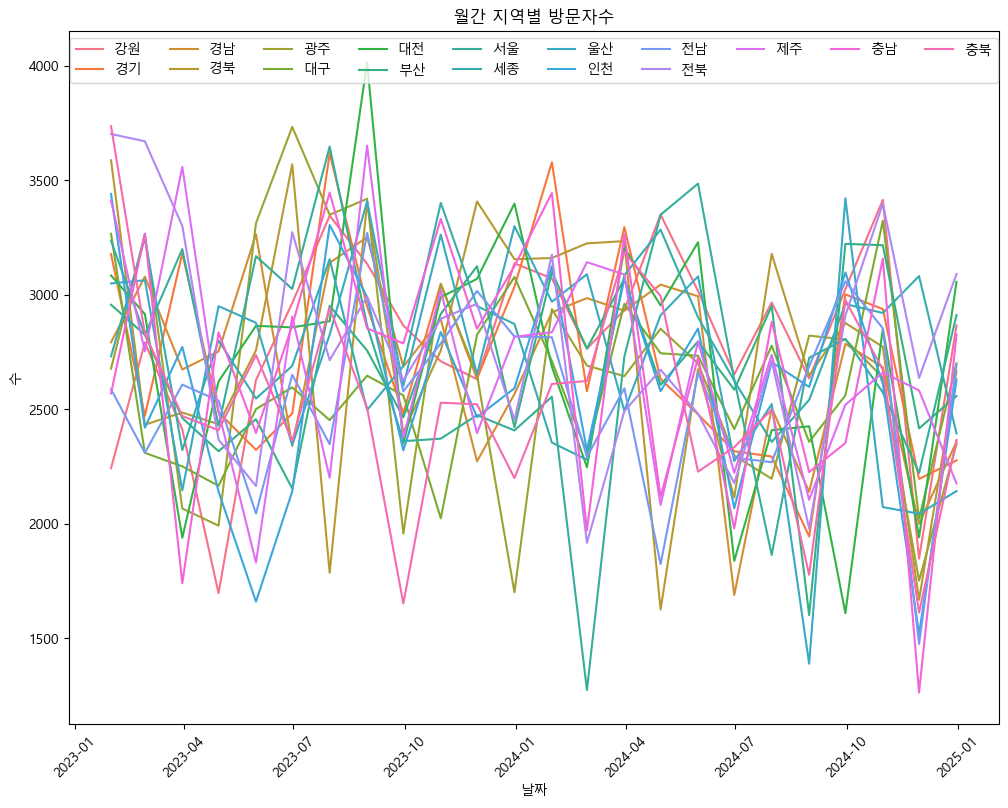

In [234]:
# 'DATE'를 월 단위로 그룹화하고 각 도시별 방문자 수를 합산
monthly_visitors = off_df_ct.groupby(['CITY', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 시각화
fig = plt.figure(figsize=(12,9))

# Seaborn으로 라인 플롯 생성 - hue를 CITY로 지정하여 지역별로 색상을 다르게 설정
sns.lineplot(data=monthly_visitors, x='DATE', y='VISITORS', hue='CITY')

plt.legend(loc='upper center', ncol=10, bbox_to_anchor=(0.5, 1))
plt.title('월간 지역별 방문자수')  # 제목 추가
plt.xlabel('날짜')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.xticks(rotation=45)  # x축 날짜 라벨을 기울여서 가독성 향상
plt.show()  # 그래프 출력

### 월간 지역별 참여자수 보기

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2105675690.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part = off_df_ct.groupby(['CITY', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


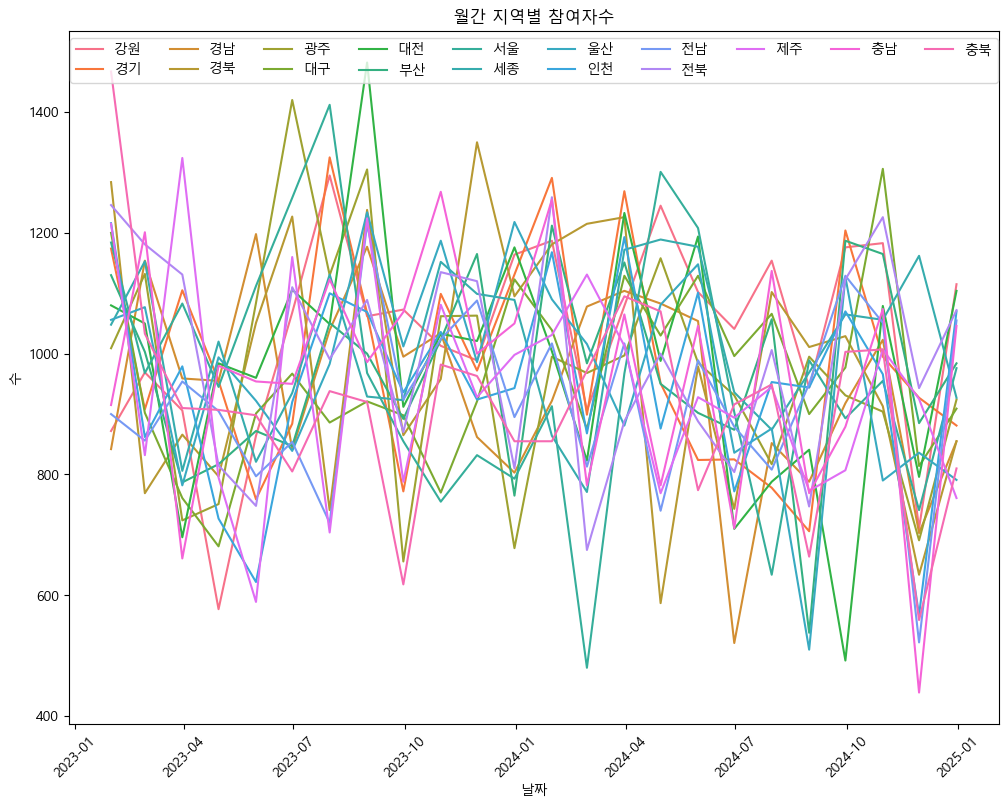

In [236]:
# 'DATE'를 월 단위로 그룹화하고 각 도시별 방문자 수를 합산
monthly_part = off_df_ct.groupby(['CITY', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 시각화
fig = plt.figure(figsize=(12,9))

# Seaborn으로 라인 플롯 생성 - hue를 CITY로 지정하여 지역별로 색상을 다르게 설정
sns.lineplot(data=monthly_part, x='DATE', y='PART', hue='CITY')

plt.legend(loc='upper center', ncol=10, bbox_to_anchor=(0.5, 1))
plt.title('월간 지역별 참여자수')  # 제목 추가
plt.xlabel('날짜')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.xticks(rotation=45)  # x축 날짜 라벨을 기울여서 가독성 향상
plt.show()  # 그래프 출력

### 지역별 방문자수, 참여자수 누적 막대그래프 시각화

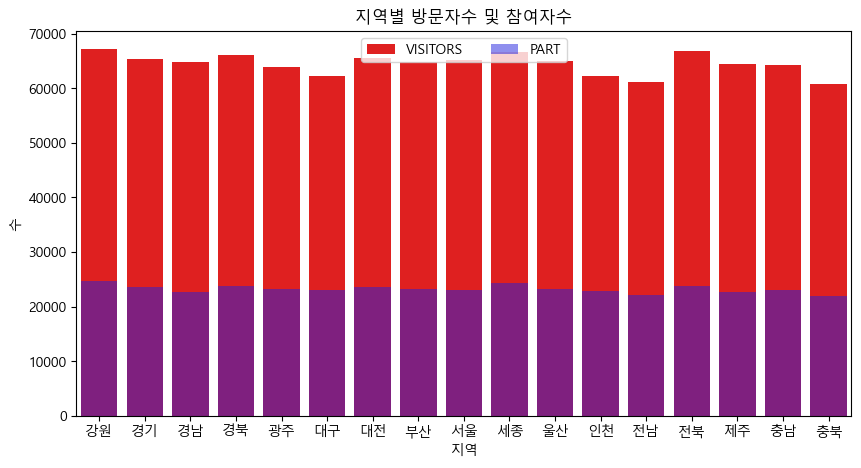

In [238]:
# 데이터 집계
vis_ct = off_df_ct.groupby(['CITY'])['VISITORS'].sum().reset_index()
part_ct = off_df_ct.groupby(['CITY'])['PART'].sum().reset_index()

# 데이터프레임 병합
combined_ct = vis_ct.merge(part_ct, on='CITY', suffixes=('_VISITORS', '_PART'))

# 바 그래프 생성
plt.figure(figsize=(10, 5))

# 방문자수와 참여자수를 나란히 그리기 위해 barplot 사용.
sns.barplot(data=combined_ct, x='CITY', y='VISITORS', color='r', label='VISITORS')
sns.barplot(data=combined_ct, x='CITY', y='PART', color='b', label='PART', alpha=0.5)

# 범례 설정
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))

# 그래프 꾸미기
plt.title('지역별 방문자수 및 참여자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.show()  # 그래프 출력

In [239]:
# 데이터 집계
vis_ct = off_df_ct.groupby(['CITY'])['VISITORS'].sum().reset_index()

# 바 그래프 생성
plt.figure(figsize=(10, 5))

# barplot 사용.
sns.barplot(data=vis_ct, x='CITY', y='VISITORS', palette='Set3')

# 그래프 꾸미기
plt.title('지역별 방문자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.ylim(50000, 70000)
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\4042721791.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vis_ct, x='CITY', y='VISITORS', palette='Set3')


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\3898072264.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=part_ct, x='CITY', y='PART', palette='Set2')


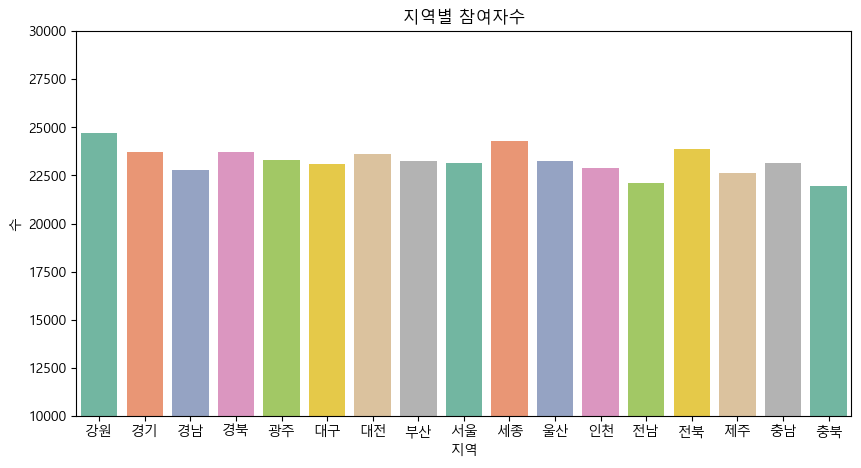

In [240]:
# 데이터 집계
part_ct = off_df_ct.groupby(['CITY'])['PART'].sum().reset_index()

# 바 그래프 생성
plt.figure(figsize=(10, 5))

# barplot 사용.
sns.barplot(data=part_ct, x='CITY', y='PART', palette='Set2')

# 그래프 꾸미기
plt.title('지역별 참여자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.ylim(10000, 30000)
plt.show()  # 그래프 출력

### 파이차트 그려보기

In [302]:
# 데이터 집계
vis_ct = off_df_ct.groupby(['CITY'])['VISITORS'].sum().reset_index()

labels = vis_ct['CITY'].unique()

plt.pie(data = vis_ct, x='VISITORS', labels=labels, autopct='%.1f%%',startangle=260)
plt.title("지역별 방문자 비율")
plt.show()

In [322]:
# 데이터 집계
part_ct = off_df_ct.groupby(['CITY'])['PART'].sum().reset_index()

labels = part_ct['CITY'].unique()
explode = [0.1 for _ in range(len(labels))]  # 모든 섹터를 약간 부풀리기

# 색상 팔레트 설정
colors = sns.color_palette("Set3", len(labels))

plt.pie(data = part_ct, x='PART', labels=labels, autopct='%.1f%%',startangle=260, 
         colors=colors, explode=explode, shadow=True)
plt.title("지역별 참여율")
plt.show()

In [325]:
off_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53480 entries, 0 to 53479
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      53480 non-null  object 
 1   지역      53480 non-null  object 
 2   방문자수    53480 non-null  int64  
 3   연령대     53480 non-null  object 
 4   성별      53480 non-null  object 
 5   이벤트 종류  53480 non-null  object 
 6   참여자수    53480 non-null  int64  
 7   참여비율    53480 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


## 캠페인 관련 시각화

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\1560796939.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_ev = off_df_ev.groupby(['CAMP', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


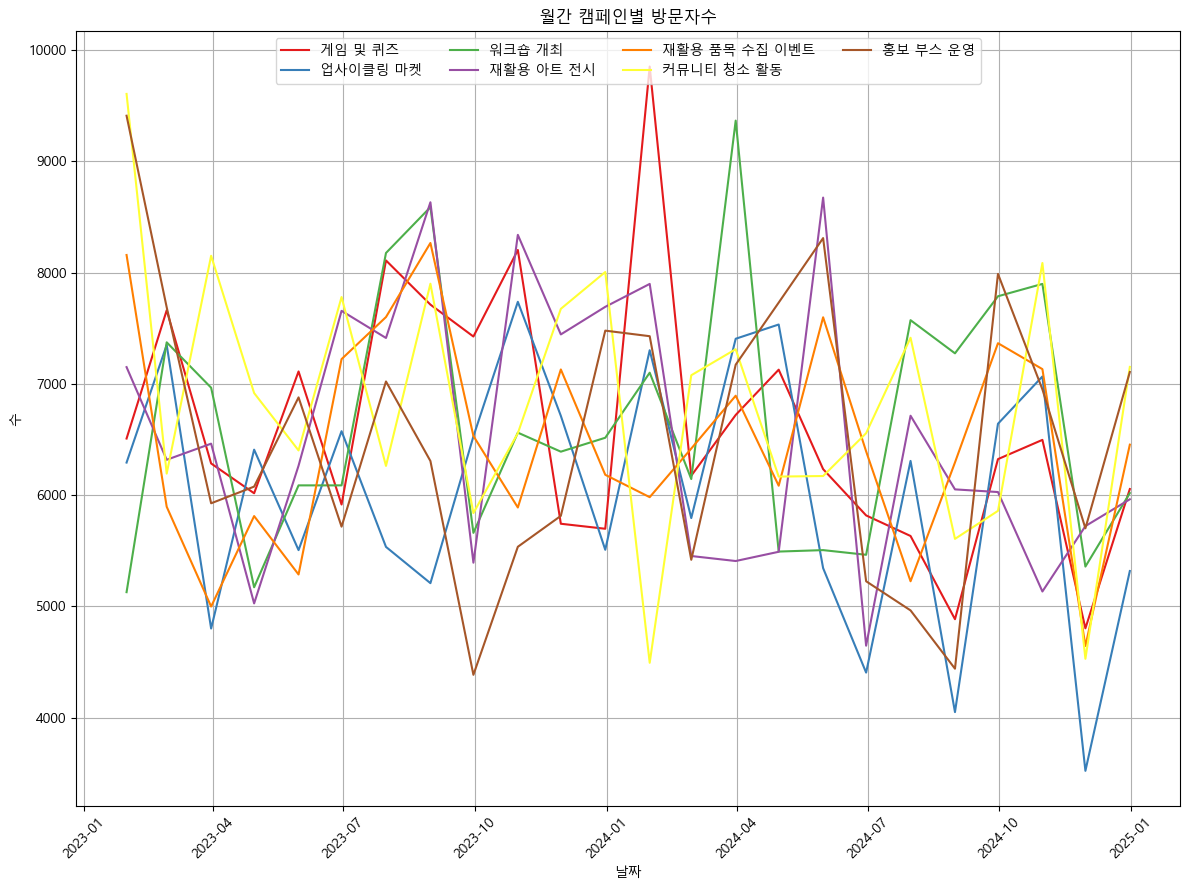

In [341]:
# 데이터 집계 및 병합
off_df_ev = off_df.groupby(['이벤트 종류', '날짜']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_ev.rename(columns={'방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '이벤트 종류': 'CAMP'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_ev['DATE'] = pd.to_datetime(off_df_ev['DATE'])

# 참여율 칼럼 추가
off_df_ev['P_Ratio'] = (off_df_ev['PART'] / off_df_ev['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 방문자 수를 합산
monthly_visit_ev = off_df_ev.groupby(['CAMP', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 9))
sns.lineplot(data=monthly_visit_ev, x='DATE', y='VISITORS', hue='CAMP', palette='Set1')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 캠페인별 방문자수')
plt.xlabel('날짜')
plt.ylabel('수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\3261228370.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_ev = off_df_ev.groupby(['CAMP', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


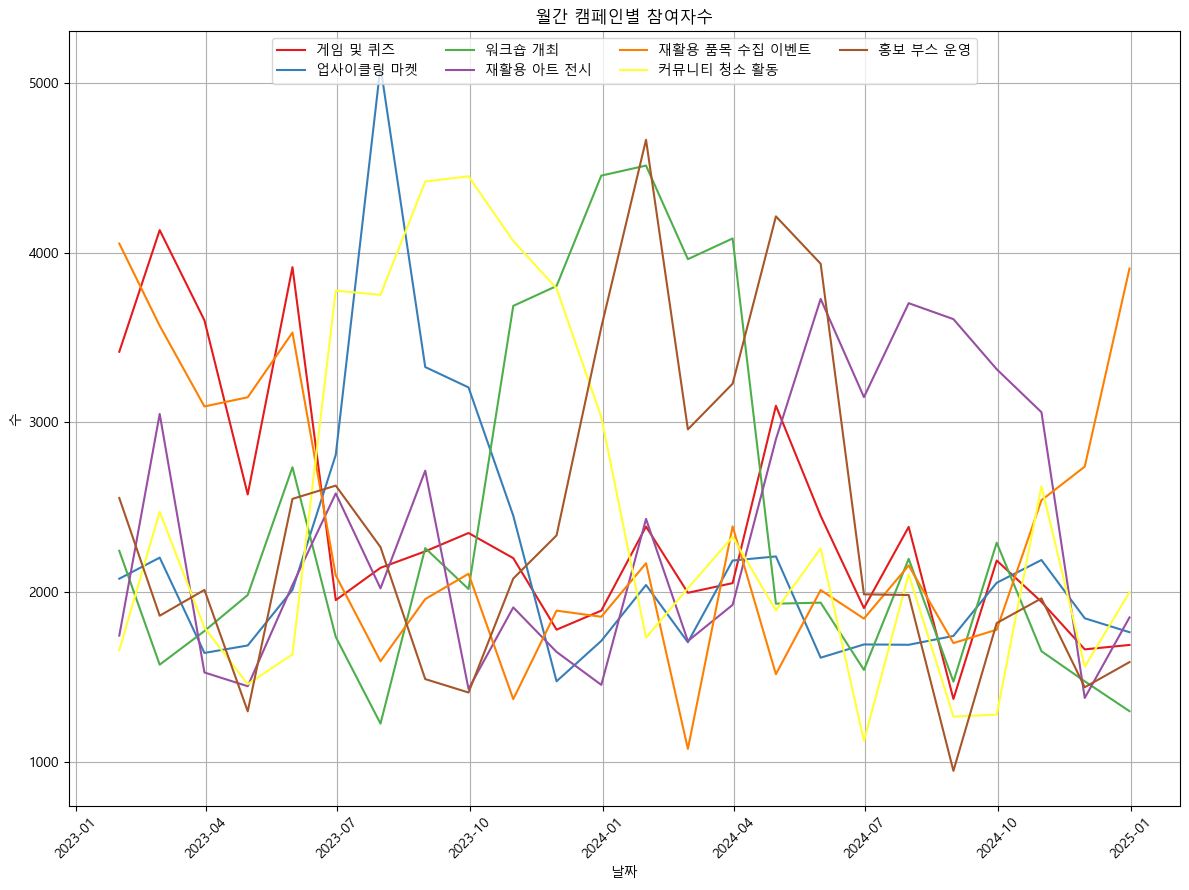

In [339]:
# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 방문자 수를 합산
monthly_part_ev = off_df_ev.groupby(['CAMP', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 9))

# Seaborn으로 라인 플롯 생성
sns.lineplot(data=monthly_part_ev, x='DATE', y='PART', hue='CAMP', palette='Set1')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 캠페인별 참여자수')  # 제목 추가
plt.xlabel('날짜')  # x축 라벨 추가
plt.ylabel('수')  # y축 라벨 추가
plt.xticks(rotation=45)  # x축 날짜 라벨 기울리기
plt.grid(True)  # 배경 그리드 추가로 가독성 향상
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

## 각 지역의 캠페인별 방문자수 누적 막대그래프

In [376]:
# 데이터 집계 및 병합
off_df_ct_ev = off_df.groupby(['이벤트 종류', '날짜', '지역']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_ct_ev.rename(columns={'지역': 'CITY', '방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '이벤트 종류': 'CAMP'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_ct_ev['DATE'] = pd.to_datetime(off_df_ct_ev['DATE'])

# 참여율 칼럼 추가
off_df_ct_ev['P_Ratio'] = (off_df_ct_ev['PART'] / off_df_ct_ev['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 지역별 방문자 수를 합산
monthly_visit_ct_ev = off_df_ct_ev.groupby(['CITY', 'CAMP', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_visit_ct_ev.pivot_table(index='CITY', columns='CAMP', values='VISITORS', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 캠페인별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 캠페인별로 누적 값 추가
for camp in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[camp], bottom=bottom_values, label=camp)
    bottom_values += pivoted_data[camp]

# 그래프 꾸미기
plt.title('캠페인누적 방문자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 방문자수')  # y축 라벨 추가
plt.legend(title='캠페인', loc='best', bbox_to_anchor=(1, 1),
           ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\597220218.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_ct_ev = off_df_ct_ev.groupby(['CITY', 'CAMP', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2317963948.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_ct_ev = off_df_ct_ev.groupby(['CITY', 'CAMP', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


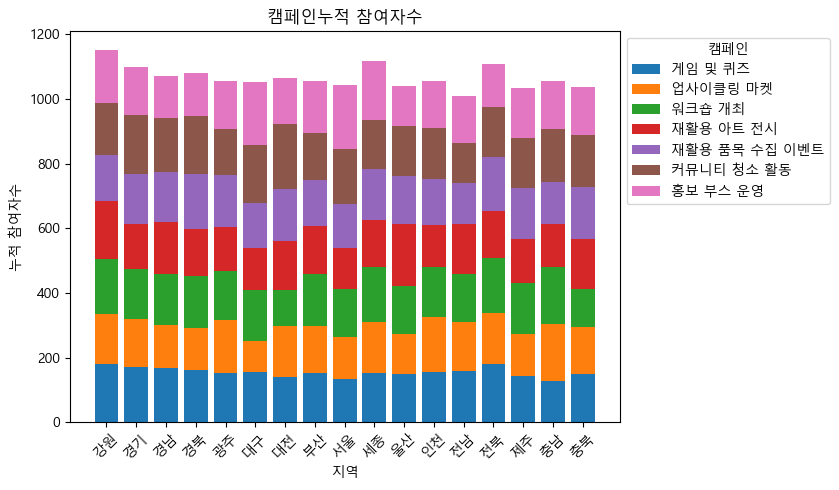

In [378]:
# 'DATE'를 월 단위로 그룹화하고 각 지역별 참여자 수를 합산
monthly_part_ct_ev = off_df_ct_ev.groupby(['CITY', 'CAMP', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_part_ct_ev.pivot_table(index='CITY', columns='CAMP', values='PART', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 캠페인별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 캠페인별로 누적 값 추가
for camp in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[camp], bottom=bottom_values, label=camp)
    bottom_values += pivoted_data[camp]

# 그래프 꾸미기
plt.title('캠페인누적 참여자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 참여자수')  # y축 라벨 추가
plt.legend(title='캠페인', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

### 캠페인별 방문비율 파이차트

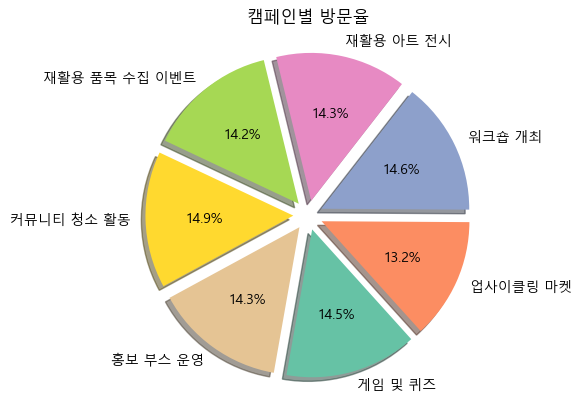

In [385]:
# 데이터 집계
vis_ev = off_df_ev.groupby(['CAMP'])['VISITORS'].sum().reset_index()

labels = vis_ev['CAMP'].unique()
explode = [0.1 for _ in range(len(labels))]  # 모든 섹터를 약간 부풀리기

# 색상 팔레트 설정
colors = sns.color_palette("Set2", len(labels))

plt.pie(data = vis_ev, x='VISITORS', labels=labels, autopct='%.1f%%',startangle=260, 
         colors=colors, explode=explode, shadow=True)
plt.title("캠페인별 방문율")
plt.show()

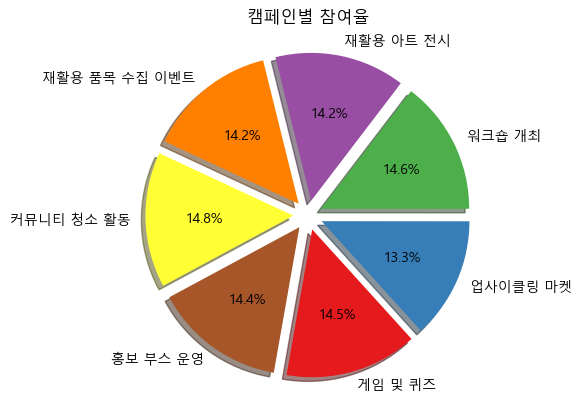

In [389]:
# 데이터 집계
part_ev = off_df_ev.groupby(['CAMP'])['PART'].sum().reset_index()

labels = part_ev['CAMP'].unique()
explode = [0.1 for _ in range(len(labels))]  # 모든 섹터를 약간 부풀리기

# 색상 팔레트 설정
colors = sns.color_palette("Set1", len(labels))

plt.pie(data = part_ev, x='PART', labels=labels, autopct='%.1f%%',startangle=260, 
         colors=colors, explode=explode, shadow=True)
plt.title("캠페인별 참여율")
plt.show()

## 연령대별 데이터 집계

In [396]:
# 데이터 집계 및 병합
off_df_age = off_df.groupby(['연령대', '날짜', '지역']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_age.rename(columns={'지역': 'CITY', '방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '연령대': 'AGE'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_age['DATE'] = pd.to_datetime(off_df_age['DATE'])

# 참여율 칼럼 추가
off_df_age['P_Ratio'] = (off_df_age['PART'] / off_df_age['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 지역별 방문자 수를 합산
monthly_visit_age = off_df_age.groupby(['CITY', 'AGE', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_visit_age.pivot_table(index='CITY', columns='AGE', values='VISITORS', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for age in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[age], bottom=bottom_values, label=age)
    bottom_values += pivoted_data[age]

# 그래프 꾸미기
plt.title('연령대별 방문자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 방문자수')  # y축 라벨 추가
plt.legend(title='연령대', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\491194233.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_age = off_df_age.groupby(['CITY', 'AGE', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


In [398]:
# 'DATE'를 월 단위로 그룹화하고 각 지역별 참여자 수를 합산
monthly_part_age = off_df_age.groupby(['CITY', 'AGE', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_part_age.pivot_table(index='CITY', columns='AGE', values='PART', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for age in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[age], bottom=bottom_values, label=age)
    bottom_values += pivoted_data[age]

# 그래프 꾸미기
plt.title('연령대별 참여자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 참여자수')  # y축 라벨 추가
plt.legend(title='연령대', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\3628280621.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_age = off_df_age.groupby(['CITY', 'AGE', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


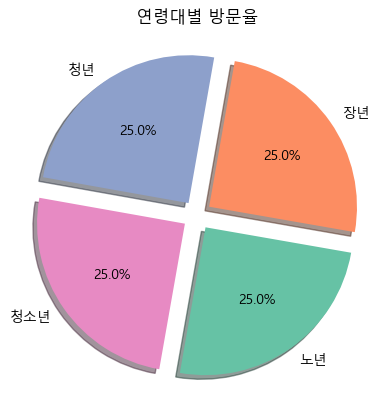

In [400]:
# 데이터 집계
vis_age = off_df_age.groupby(['AGE'])['VISITORS'].sum().reset_index()

labels = vis_age['AGE'].unique()
explode = [0.1 for _ in range(len(labels))]  # 모든 섹터를 약간 부풀리기

# 색상 팔레트 설정
colors = sns.color_palette("Set2", len(labels))

plt.pie(data = vis_age, x='VISITORS', labels=labels, autopct='%.1f%%',startangle=260, 
         colors=colors, explode=explode, shadow=True)
plt.title("연령대별 방문율")
plt.show()

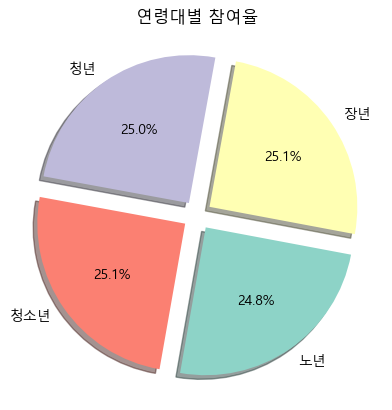

In [402]:
# 데이터 집계
part_age = off_df_age.groupby(['AGE'])['PART'].sum().reset_index()

labels = part_age['AGE'].unique()
explode = [0.1 for _ in range(len(labels))]  # 모든 섹터를 약간 부풀리기

# 색상 팔레트 설정
colors = sns.color_palette("Set3", len(labels))

plt.pie(data = part_age, x='PART', labels=labels, autopct='%.1f%%',startangle=260, 
         colors=colors, explode=explode, shadow=True)
plt.title("연령대별 참여율")
plt.show()

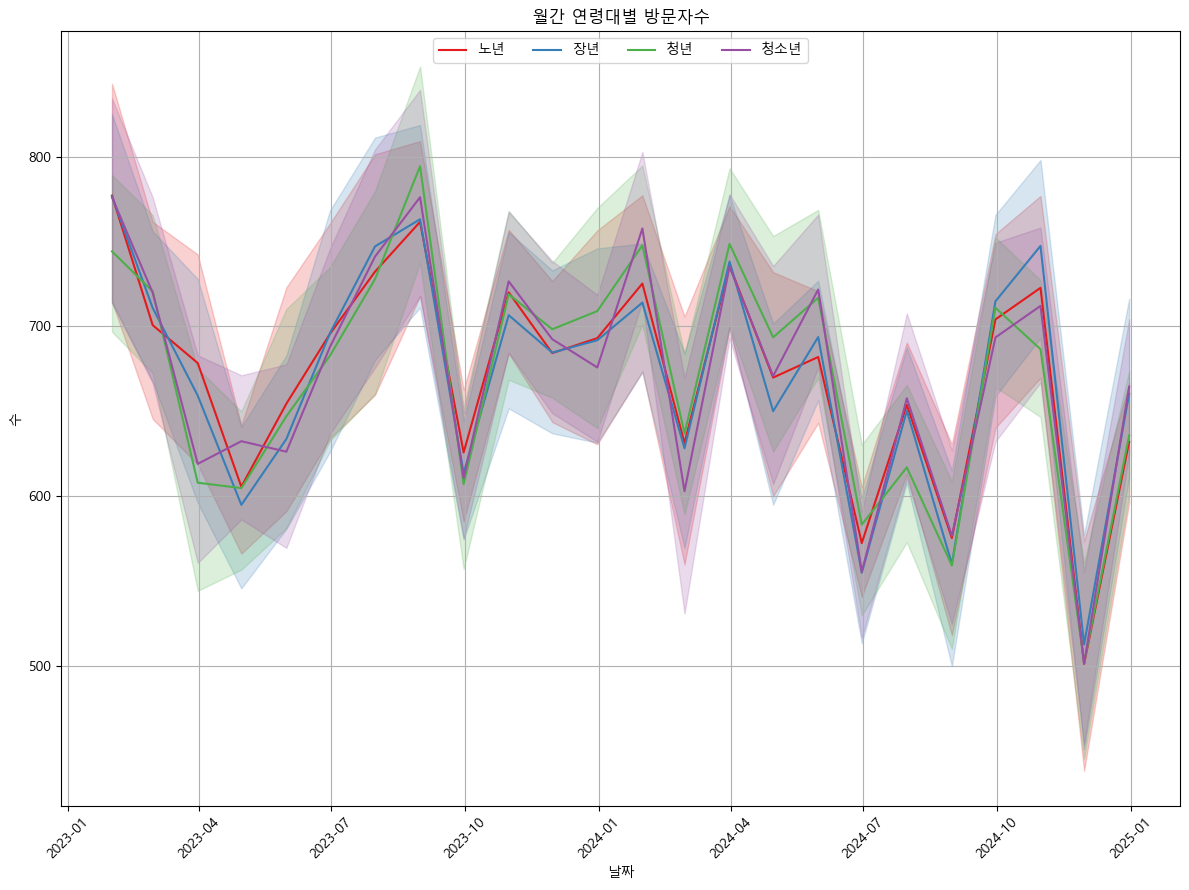

In [404]:
# 시각화
plt.figure(figsize=(12, 9))
sns.lineplot(data=monthly_visit_age, x='DATE', y='VISITORS', hue='AGE', palette='Set1')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 연령대별 방문자수')
plt.xlabel('날짜')
plt.ylabel('수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

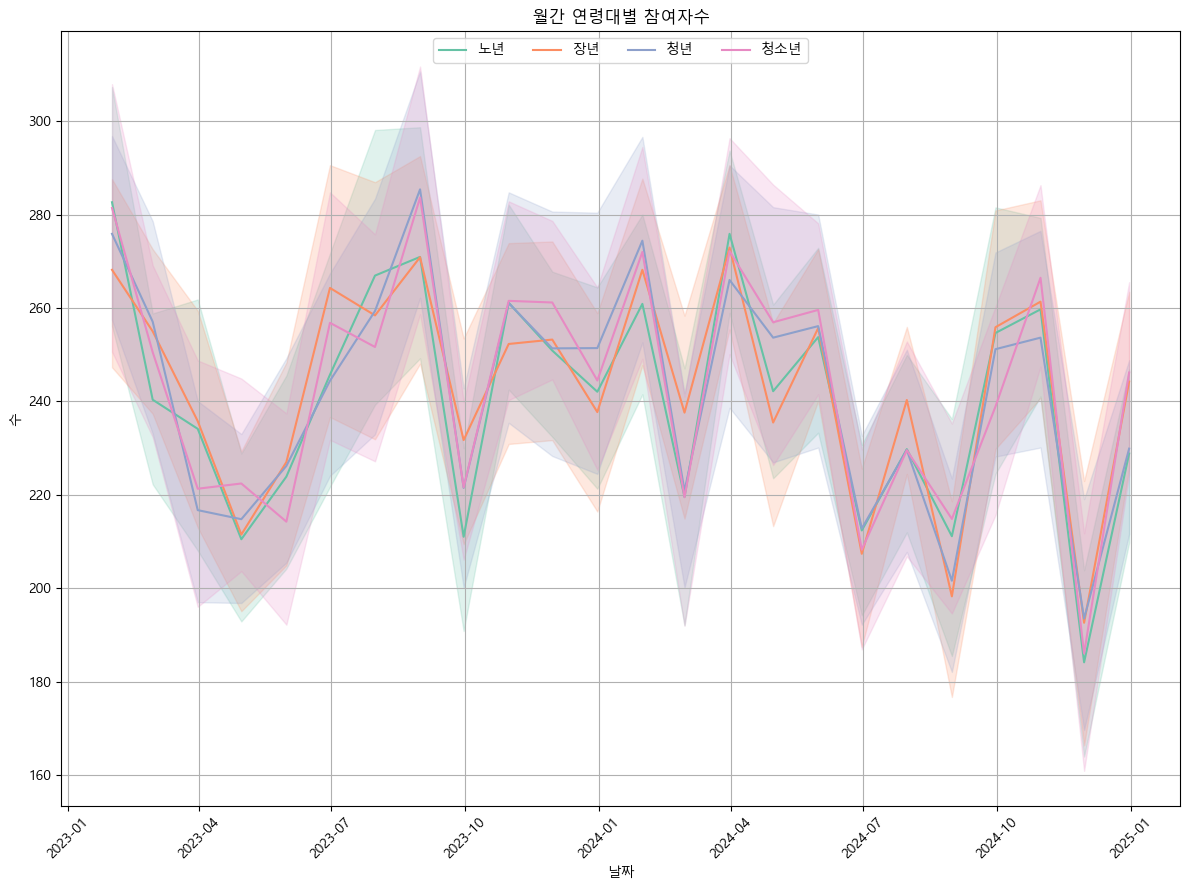

In [406]:
# 시각화
plt.figure(figsize=(12, 9))
sns.lineplot(data=monthly_part_age, x='DATE', y='PART', hue='AGE', palette='Set2')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 연령대별 참여자수')
plt.xlabel('날짜')
plt.ylabel('수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\4219745818.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_ev_age = off_df_ev_age.groupby(['CAMP', 'AGE', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


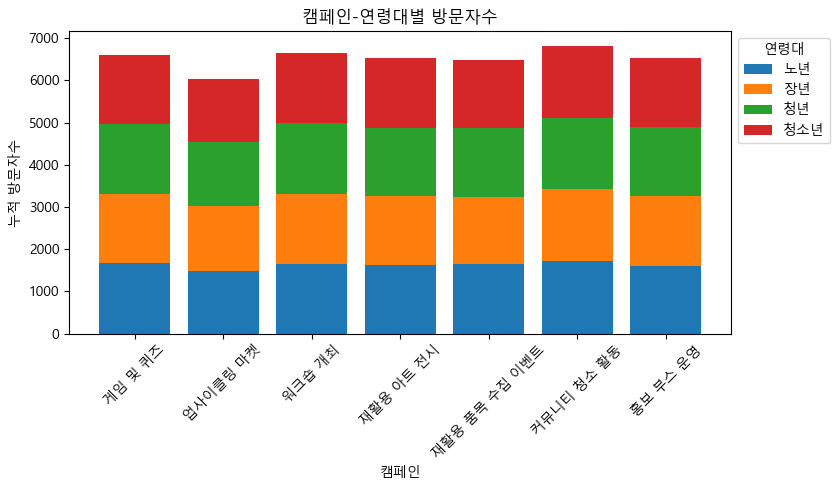

In [412]:
# 데이터 집계 및 병합
off_df_ev_age = off_df.groupby(['연령대', '날짜', '이벤트 종류']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_ev_age.rename(columns={'이벤트 종류': 'CAMP', '방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '연령대': 'AGE'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_ev_age['DATE'] = pd.to_datetime(off_df_ev_age['DATE'])

# 참여율 칼럼 추가
off_df_ev_age['P_Ratio'] = (off_df_ev_age['PART'] / off_df_ev_age['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 참여자 수를 합산
monthly_visit_ev_age = off_df_ev_age.groupby(['CAMP', 'AGE', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_visit_ev_age.pivot_table(index='CAMP', columns='AGE', values='VISITORS', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for age in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[age], bottom=bottom_values, label=age)
    bottom_values += pivoted_data[age]

# 그래프 꾸미기
plt.title('캠페인-연령대별 방문자수')  # 제목 추가
plt.xlabel('캠페인')  # x축 라벨 추가
plt.ylabel('누적 방문자수')  # y축 라벨 추가
plt.legend(title='연령대', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\4075378373.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_ev_age = off_df_ev_age.groupby(['CAMP', 'AGE', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


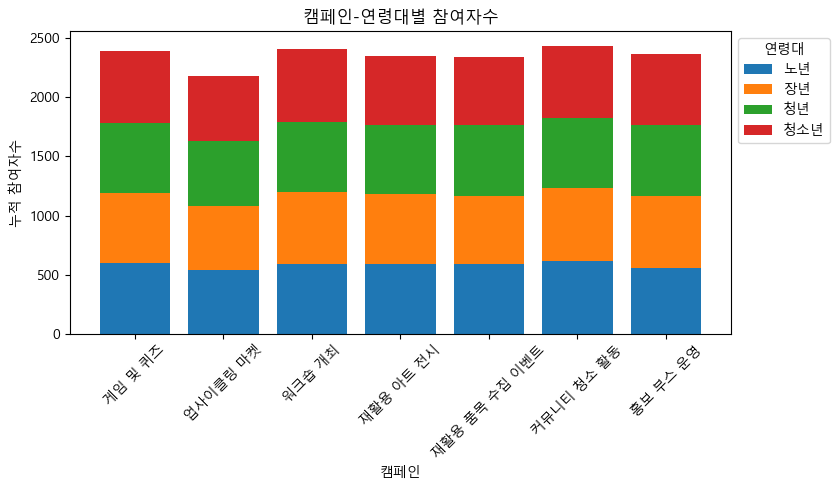

In [416]:
# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 참여자 수를 합산
monthly_part_ev_age = off_df_ev_age.groupby(['CAMP', 'AGE', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_part_ev_age.pivot_table(index='CAMP', columns='AGE', values='PART', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for age in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[age], bottom=bottom_values, label=age)
    bottom_values += pivoted_data[age]

# 그래프 꾸미기
plt.title('캠페인-연령대별 참여자수')  # 제목 추가
plt.xlabel('캠페인')  # x축 라벨 추가
plt.ylabel('누적 참여자수')  # y축 라벨 추가
plt.legend(title='연령대', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

In [419]:
off_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53480 entries, 0 to 53479
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      53480 non-null  object 
 1   지역      53480 non-null  object 
 2   방문자수    53480 non-null  int64  
 3   연령대     53480 non-null  object 
 4   성별      53480 non-null  object 
 5   이벤트 종류  53480 non-null  object 
 6   참여자수    53480 non-null  int64  
 7   참여비율    53480 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


## 성별 데이터 분석

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2297406895.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_gender = off_df_gender.groupby(['CITY', 'GENDER', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


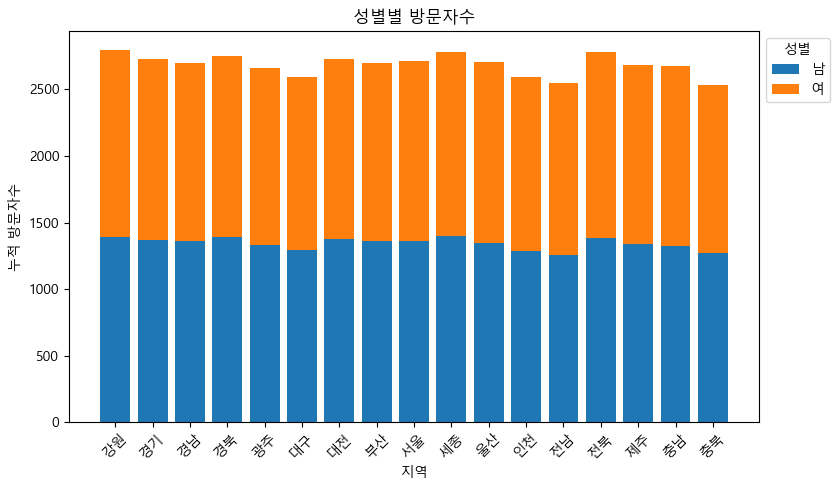

In [421]:
# 데이터 집계 및 병합
off_df_gender = off_df.groupby(['성별', '날짜', '지역']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_gender.rename(columns={'지역': 'CITY', '방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '성별': 'GENDER'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_gender['DATE'] = pd.to_datetime(off_df_gender['DATE'])

# 참여율 칼럼 추가
off_df_gender['P_Ratio'] = (off_df_gender['PART'] / off_df_gender['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 지역별 방문자 수를 합산
monthly_visit_gender = off_df_gender.groupby(['CITY', 'GENDER', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_visit_gender.pivot_table(index='CITY', columns='GENDER', values='VISITORS', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for gender in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[gender], bottom=bottom_values, label=gender)
    bottom_values += pivoted_data[gender]

# 그래프 꾸미기
plt.title('성별별 방문자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 방문자수')  # y축 라벨 추가
plt.legend(title='성별', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\4223139332.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_gender = off_df_gender.groupby(['CITY', 'GENDER', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


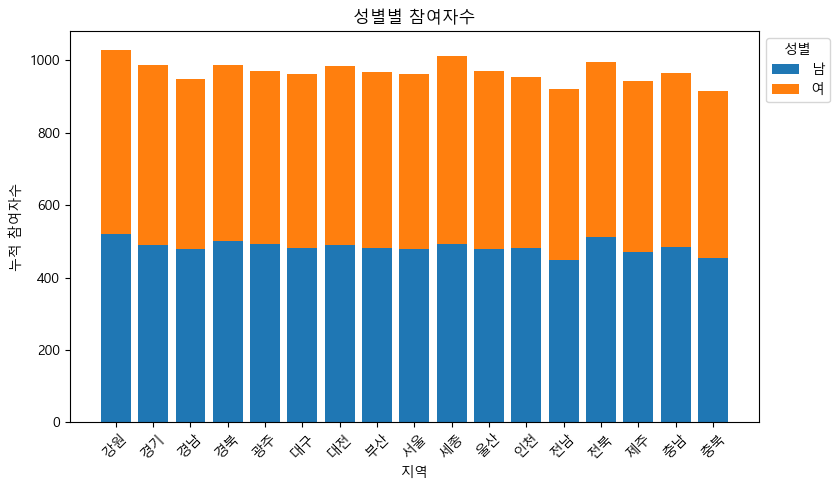

In [423]:
# 'DATE'를 월 단위로 그룹화하고 각 지역별 참여자 수를 합산
monthly_part_gender = off_df_gender.groupby(['CITY', 'GENDER', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_part_gender.pivot_table(index='CITY', columns='GENDER', values='PART', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for gender in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[gender], bottom=bottom_values, label=gender)
    bottom_values += pivoted_data[gender]

# 그래프 꾸미기
plt.title('성별별 참여자수')  # 제목 추가
plt.xlabel('지역')  # x축 라벨 추가
plt.ylabel('누적 참여자수')  # y축 라벨 추가
plt.legend(title='성별', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

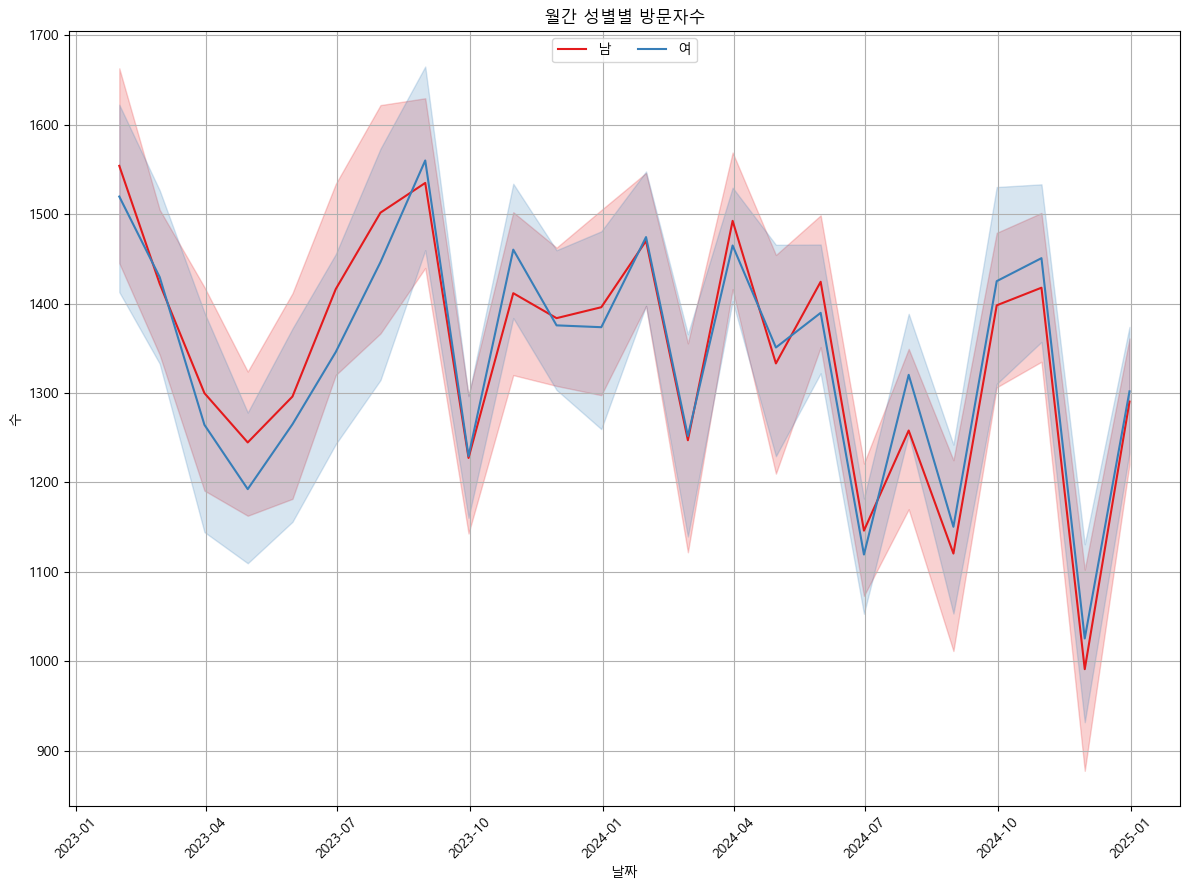

In [425]:
# 시각화
plt.figure(figsize=(12, 9))
sns.lineplot(data=monthly_visit_gender, x='DATE', y='VISITORS', hue='GENDER', palette='Set1')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 성별별 방문자수')
plt.xlabel('날짜')
plt.ylabel('수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

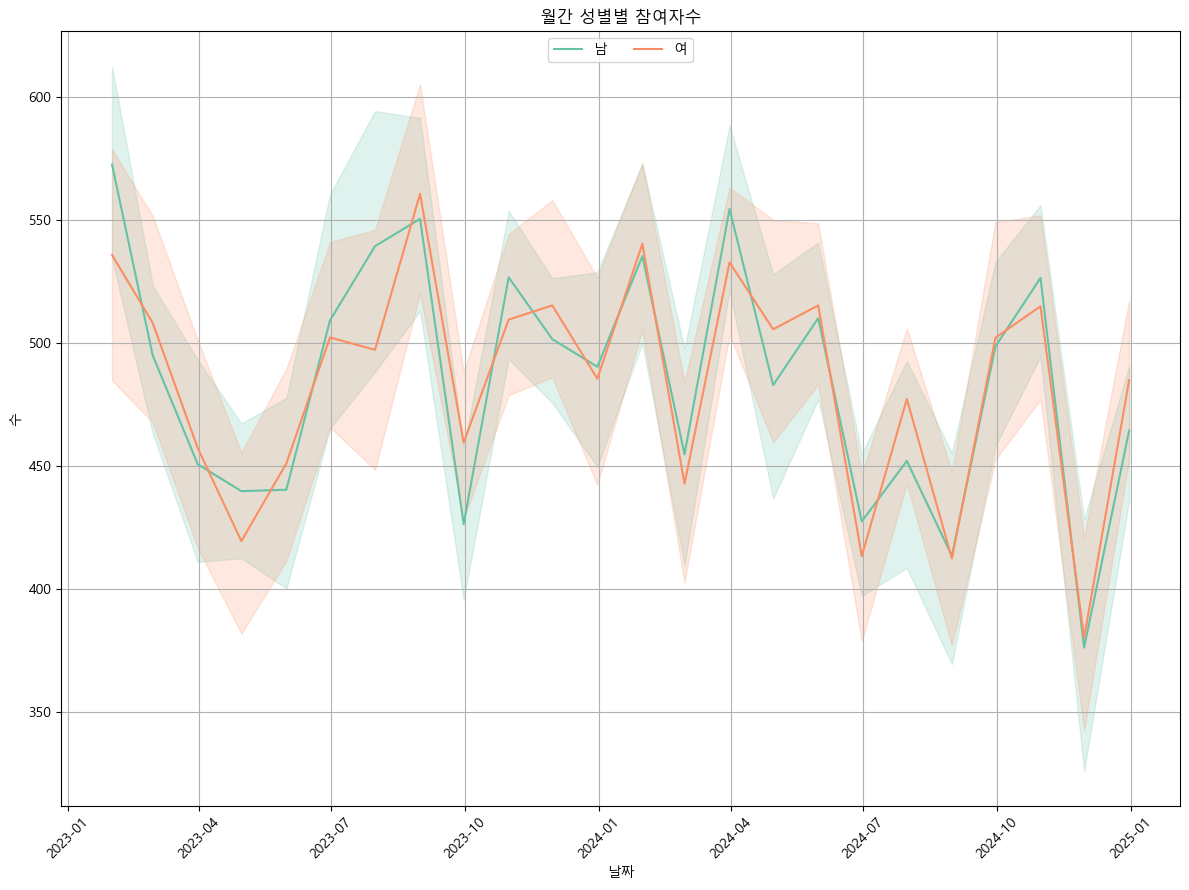

In [427]:
# 시각화
plt.figure(figsize=(12, 9))
sns.lineplot(data=monthly_part_gender, x='DATE', y='PART', hue='GENDER', palette='Set2')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('월간 성별별 참여자수')
plt.xlabel('날짜')
plt.ylabel('수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2862997947.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visit_ev_gender = off_df_ev_gender.groupby(['CAMP', 'GENDER', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()


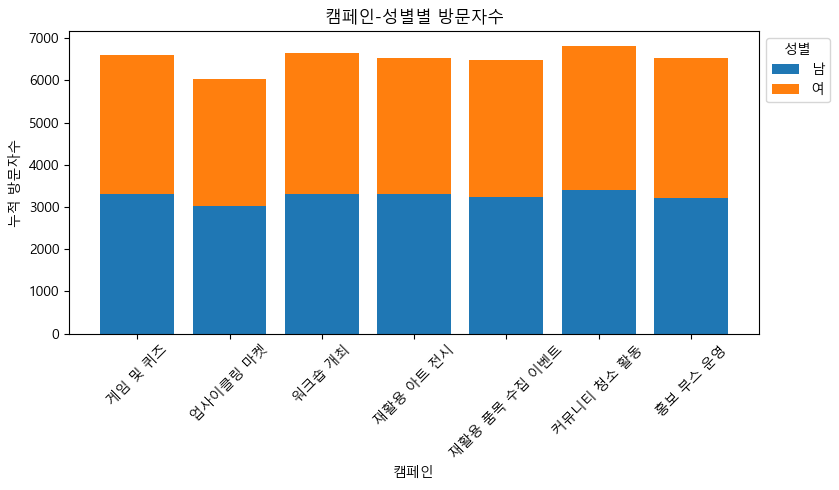

In [429]:
# 데이터 집계 및 병합
off_df_ev_gender = off_df.groupby(['성별', '날짜', '이벤트 종류']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_ev_gender.rename(columns={'이벤트 종류': 'CAMP', '방문자수': 'VISITORS', '참여자수': 'PART', '날짜': 'DATE', '성별': 'GENDER'}, inplace=True)

# 날짜를 datetime으로 형변환
off_df_ev_gender['DATE'] = pd.to_datetime(off_df_ev_gender['DATE'])

# 참여율 칼럼 추가
off_df_ev_gender['P_Ratio'] = (off_df_ev_gender['PART'] / off_df_ev_gender['VISITORS']) * 100

# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 참여자 수를 합산
monthly_visit_ev_gender = off_df_ev_gender.groupby(['CAMP', 'GENDER', pd.Grouper(key='DATE', freq='M')])['VISITORS'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_visit_ev_gender.pivot_table(index='CAMP', columns='GENDER', values='VISITORS', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for gender in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[gender], bottom=bottom_values, label=gender)
    bottom_values += pivoted_data[gender]

# 그래프 꾸미기
plt.title('캠페인-성별별 방문자수')  # 제목 추가
plt.xlabel('캠페인')  # x축 라벨 추가
plt.ylabel('누적 방문자수')  # y축 라벨 추가
plt.legend(title='성별', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9580\2518848449.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_part_ev_gender = off_df_ev_gender.groupby(['CAMP', 'GENDER', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()


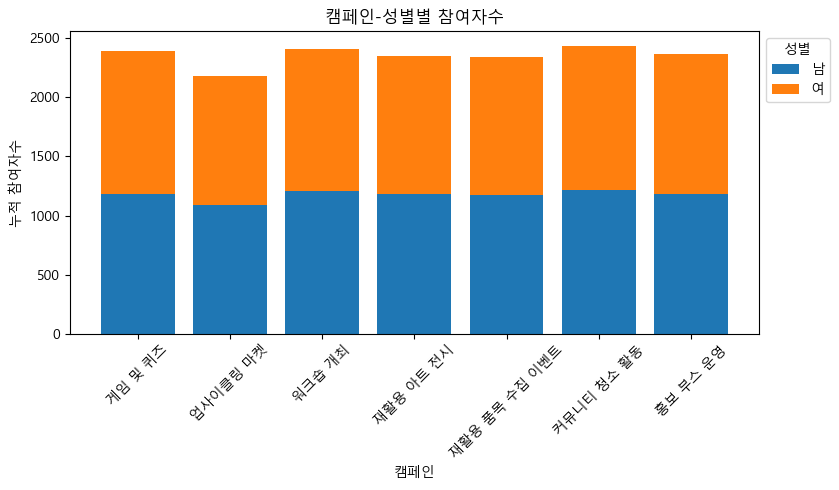

In [433]:
# 'DATE'를 월 단위로 그룹화하고 각 캠페인별 참여자 수를 합산
monthly_part_ev_gender = off_df_ev_gender.groupby(['CAMP', 'GENDER', pd.Grouper(key='DATE', freq='M')])['PART'].sum().reset_index()

# 그래프를 그릴 수 있도록 데이터 피벗
pivoted_data = monthly_part_ev_gender.pivot_table(index='CAMP', columns='GENDER', values='PART', fill_value=0)

# 누적 막대그래프 생성
plt.figure(figsize=(10, 5))

# 각 연령대별로 누적 막대 그래프를 그리기 위한 시작 지점
bottom_values = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

# 각 연령대별로 누적 값 추가
for gender in pivoted_data.columns:
    plt.bar(pivoted_data.index, pivoted_data[gender], bottom=bottom_values, label=gender)
    bottom_values += pivoted_data[gender]

# 그래프 꾸미기
plt.title('캠페인-성별별 참여자수')  # 제목 추가
plt.xlabel('캠페인')  # x축 라벨 추가
plt.ylabel('누적 참여자수')  # y축 라벨 추가
plt.legend(title='성별', loc='best', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # 범례 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 레이아웃 조정하여 그래프 안쪽 공간 늘리기
plt.show()  # 그래프 출력

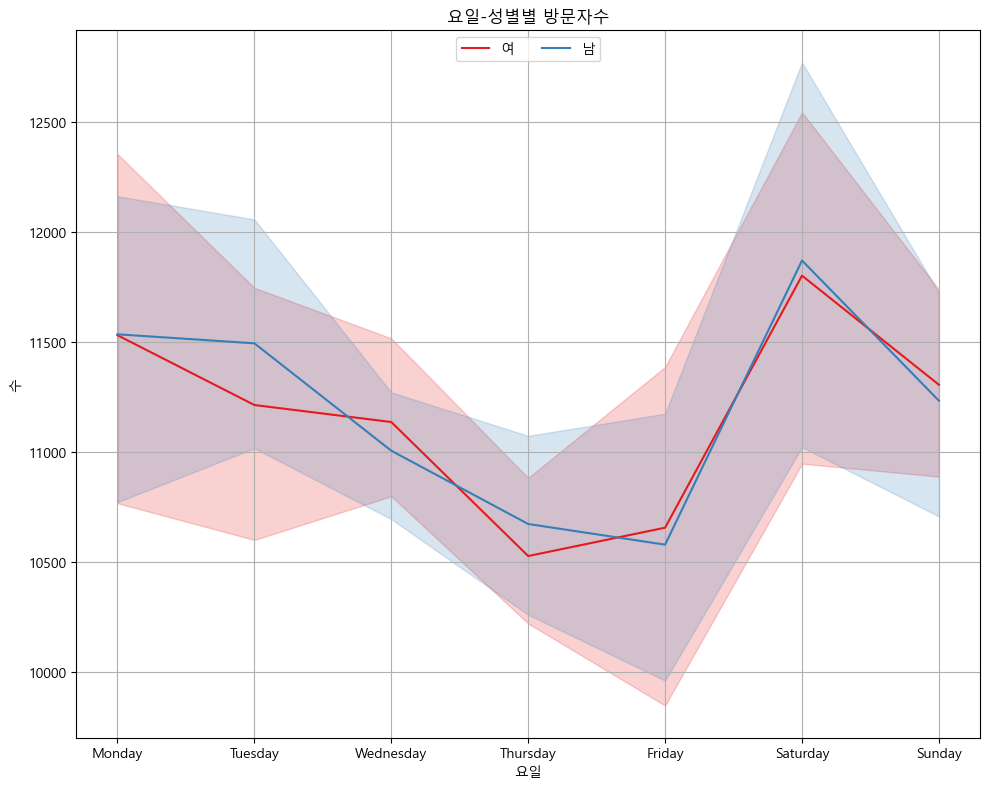

In [463]:
# 데이터 집계 및 병합
off_df_day = off_df.groupby(['성별', '날짜', '이벤트 종류']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_day.rename(columns={'날짜': 'DATE', '이벤트 종류': 'CAMP', '성별': 'GENDER', 
                            '방문자수': 'VISITORS', '참여자수': 'PART'}, inplace=True)

# 데이터의 날짜를 날짜 데이터로 형변환
off_df_day['DATE'] = pd.to_datetime(off_df_day['DATE'])

# 요일 정보 추가
off_df_day['DAY_OF_WEEK'] = off_df_day['DATE'].dt.day_name()  # 요일 이름 추가

# 'DAY_OF_WEEK'와 '이벤트 종류', '성별'로 그룹화하고 참여자 수 합산
day_visit_ev_gender = off_df_day.groupby(['CAMP', 'GENDER', 'DAY_OF_WEEK'])['VISITORS'].sum().reset_index()

# 요일 순서 정렬
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_visit_ev_gender['DAY_OF_WEEK'] = pd.Categorical(day_visit_ev_gender['DAY_OF_WEEK'], categories=day_order, ordered=True)

# 데이터를 요일별로 정렬
day_visit_ev_gender = day_visit_ev_gender.sort_values(by='DAY_OF_WEEK').reset_index(drop=True)

# 시각화
plt.figure(figsize=(10, 8))
sns.lineplot(data=day_visit_ev_gender, x='DAY_OF_WEEK', y='VISITORS', hue='GENDER', palette='Set1')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('요일-성별별 방문자수')
plt.xlabel('요일')
plt.ylabel('수')
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()

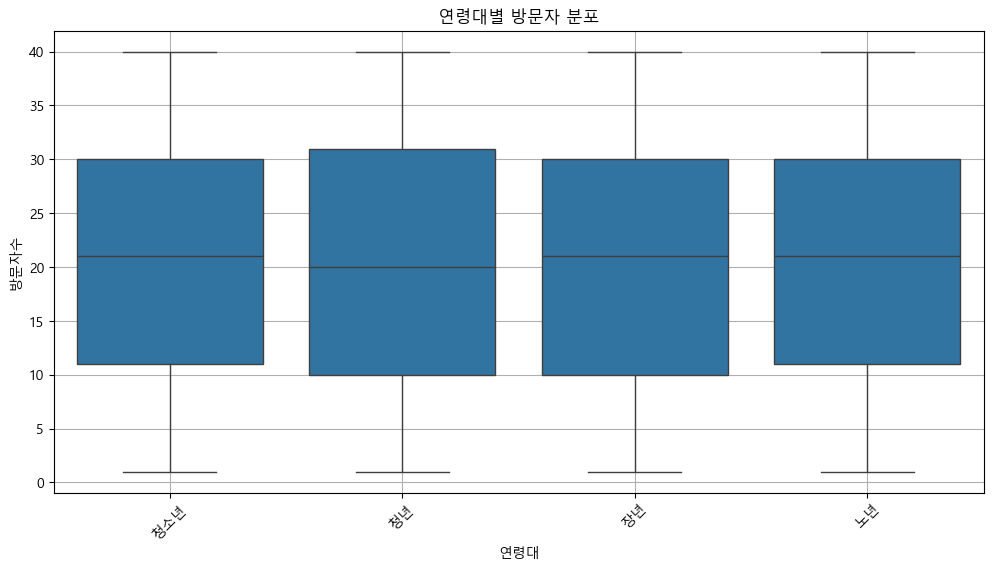

In [498]:
# 연령대에 따른 방문자 수의 상자 그림
plt.figure(figsize=(12, 6))
sns.boxplot(x='연령대', y='방문자수', data=off_df)
plt.title('연령대별 방문자 분포')
plt.xlabel('연령대')
plt.ylabel('방문자수')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

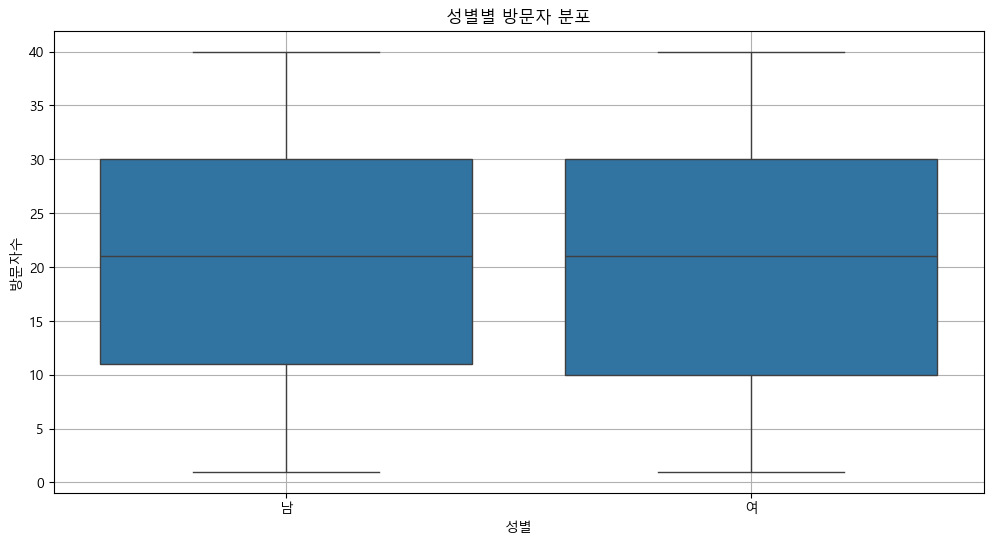

In [500]:
# 성별에 따른 방문자 수의 상자 그림
plt.figure(figsize=(12, 6))
sns.boxplot(x='성별', y='방문자수', data=off_df)
plt.title('성별별 방문자 분포')
plt.xlabel('성별')
plt.ylabel('방문자수')
plt.grid(True)
plt.show()

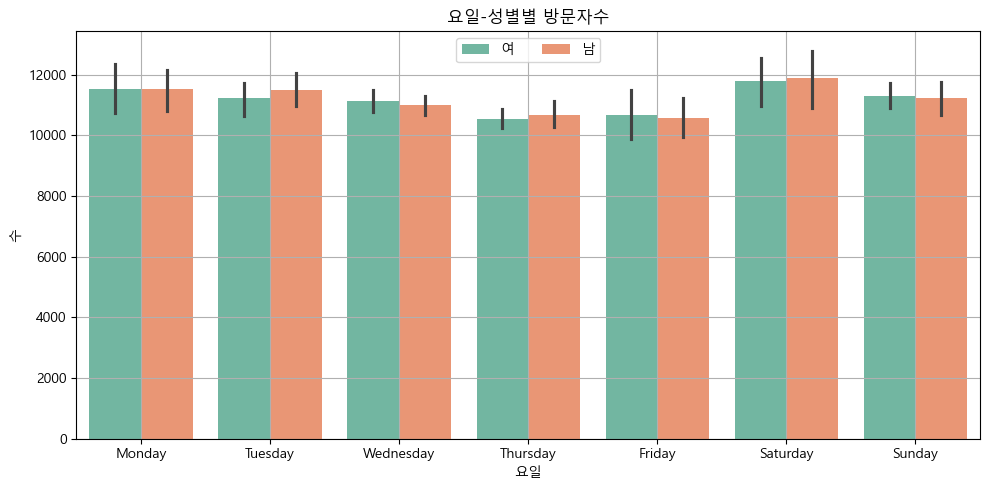

In [461]:
# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=day_visit_ev_gender, x='DAY_OF_WEEK', y='VISITORS', hue='GENDER', palette='Set2')

# 그래프 꾸미기
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.title('요일-성별별 방문자수')
plt.xlabel('요일')
plt.ylabel('수')
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()

In [524]:
file_path = 'https://raw.githubusercontent.com/jjjjunn/YH_project/refs/heads/main/'

off_df = pd.read_csv(file_path + 'recycling_off.csv')
off_df.head()

날짜  지역  방문자수  연령대 성별    이벤트 종류  참여자수       참여비율
0  2023-01-01  인천    36  청소년  남  업사이클링 마켓     6  16.666667
1  2023-01-01  인천    40  청소년  여  업사이클링 마켓     4  10.000000
2  2023-01-01  인천    12   청년  남  업사이클링 마켓     3  25.000000
3  2023-01-01  인천    13   청년  여  업사이클링 마켓     5  38.461538
4  2023-01-01  인천     1   장년  남  업사이클링 마켓     0   0.000000

## 머신러닝 진행하기

In [526]:
# 시계열 분석

# 날짜를 datetime 형식으로 변환
off_df['날짜'] = pd.to_datetime(off_df['날짜'])

# 데이터 집계 및 병합
off_df_day = off_df.groupby(['날짜']).agg({'방문자수': 'sum', '참여자수': 'sum'}).reset_index()

# 컬럼 이름 변경
off_df_day.rename(columns={'날짜': 'DATE', '방문자수': 'VISITORS', '참여자수': 'PART'}, inplace=True)

# 날짜를 인덱스로 설정
off_df_day.set_index('DATE', inplace=True)

# 방문자 수 데이터 추출
visitor_data = off_df_day['VISITORS']

print(visitor_data.head())

DATE
2023-01-01    1380
2023-01-02     773
2023-01-03    1815
2023-01-04    1848
2023-01-05     639
Name: VISITORS, dtype: int64


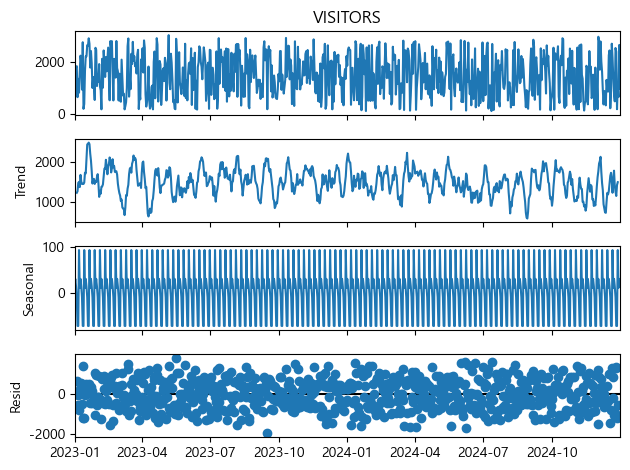

In [528]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 데이터 분해
decomposition = seasonal_decompose(visitor_data, model='additive')
fig = decomposition.plot()
plt.show()

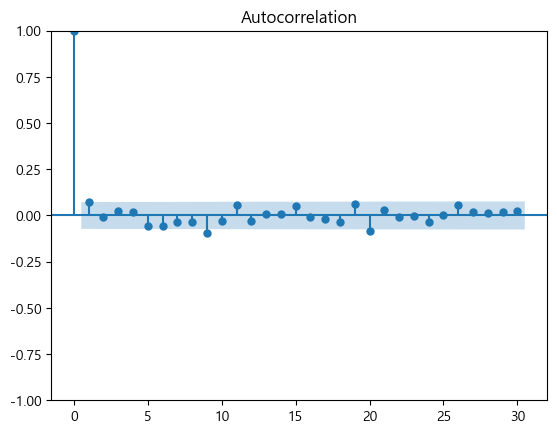

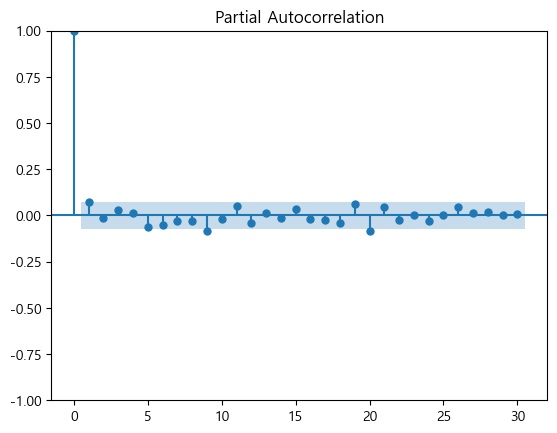

C:\Users\402\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\402\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\402\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               VISITORS   No. Observations:                  731
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5924.720
Date:                Thu, 20 Mar 2025   AIC                          11855.441
Time:                        17:45:20   BIC                          11869.220
Sample:                    01-01-2023   HQIC                         11860.757
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0765      0.037      2.076      0.038       0.004       0.149
ma.L1         -1.0000      0.288     -3.473      0.001      -1.564      -0.436
sigma2      6.505e+05   1.91e+05      3.407      0.0

In [530]:
# ARIMA 모델링

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# ACF 및 PACF 플롯하기
fig = sm.graphics.tsa.plot_acf(visitor_data, lags=30)
fig = sm.graphics.tsa.plot_pacf(visitor_data, lags=30)
plt.show()

# ARIMA 모델 설정 (p, d, q는 ACF와 PACF 결과를 바탕으로 결정)
model = ARIMA(visitor_data, order=(1, 1, 1))
results = model.fit()

# 결과 요약
print(results.summary())

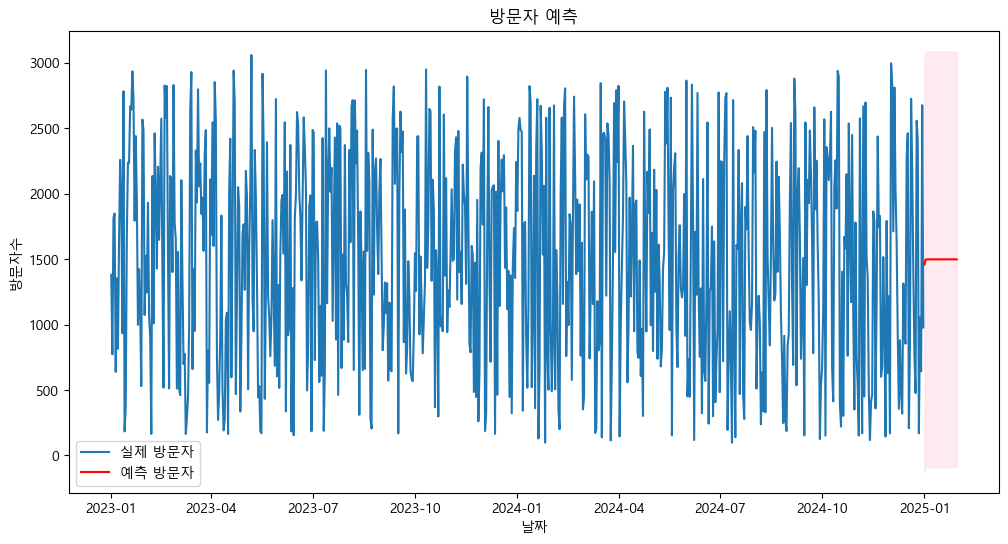

In [532]:
# 향후 30일를 예측
forecast = results.get_forecast(steps=30)
forecast_index = pd.date_range(start=visitor_data.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_values = forecast.predicted_mean

# 신뢰구간 계산
confidence_intervals = forecast.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(visitor_data.index, visitor_data, label='실제 방문자')
plt.plot(forecast_index, forecast_values, label='예측 방문자', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('방문자 예측')
plt.xlabel('날짜')
plt.ylabel('방문자수')
plt.legend(loc='best')
plt.show()

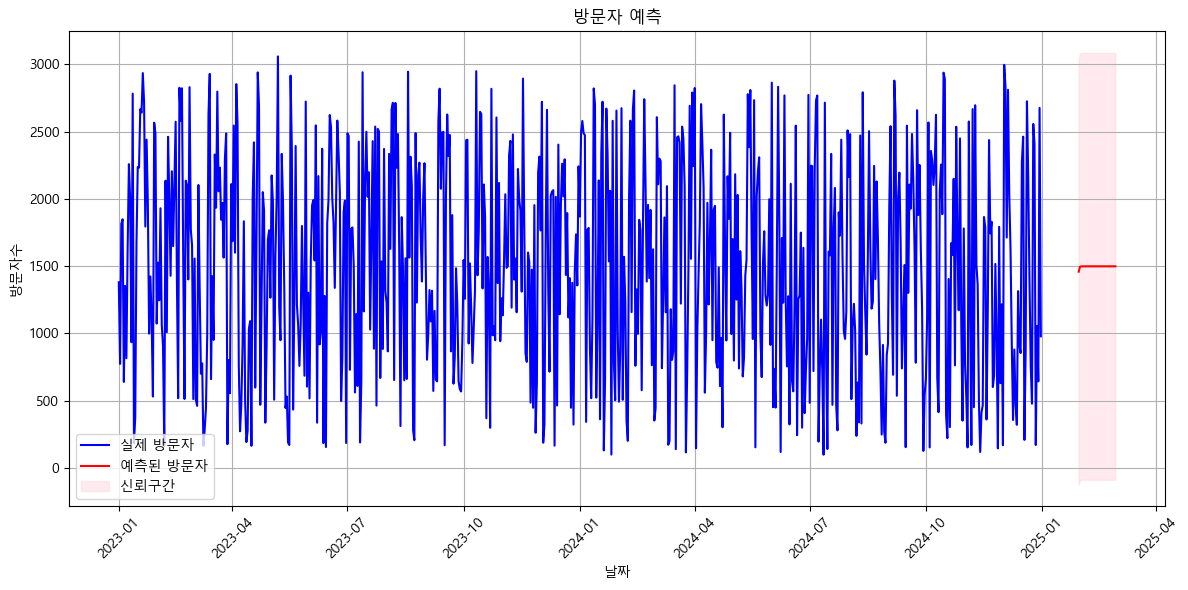

In [494]:
# 미래 예측 기간 설정
forecast_index = pd.date_range(start=visitor_data.index[-1] + pd.Timedelta(days=30), periods=30)

# 예측된 방문자 수와 신뢰 구간 설정
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 시각화
plt.figure(figsize=(12, 6))

# 실제 방문자 수 플롯
plt.plot(visitor_data.index, visitor_data, label='실제 방문자', color='blue')

# 예측된 방문자 수 플롯
plt.plot(forecast_index, forecast_values, label='예측된 방문자', color='red')

# 신뢰 구간 시각화
plt.fill_between(forecast_index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='신뢰구간')

# 그래프 제목 및 레이블
plt.title('방문자 예측')
plt.xlabel('날짜')
plt.ylabel('방문자수')
plt.legend()
plt.xticks(rotation=45)  # x축 레이블 회전
plt.grid(True)  # 그리드 추가
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력